In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/Machine_Learning_2025_2/trabajo_final

combined_keyboard_data.csv   merged_keyboard_data_20260110_142312.csv
data-evaluation.ipynb	     modelo.ipynb
keyboard-data-christian.csv


# Paso 0: Merge Datasets

In [14]:
import pandas as pd
import numpy as np

# Rutas de los archivos
file1 = 'drive/MyDrive/Machine_Learning_2025_2/trabajo_final/keyboard-data-christian.csv'
file2 = 'drive/MyDrive/Machine_Learning_2025_2/trabajo_final/merged_keyboard_data_20260110_142312.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
print(df1.shape)
print(df2.shape)

df_merged = pd.concat([df1, df2], axis=0, ignore_index=True, sort=False)

print(f' DF merged: {df_merged.shape}')

output_file = 'drive/MyDrive/Machine_Learning_2025_2/trabajo_final/combined_keyboard_data.csv'
df_merged.to_csv(output_file, index=False)



(17280, 112)
(36218, 220)
 DF merged: (53498, 250)


# Paso 1: Cargar datos  recolectado

In [15]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('drive/MyDrive/Machine_Learning_2025_2/trabajo_final/combined_keyboard_data.csv')
print(df.shape)


(53498, 250)


# Paso 2: Definir el tamaño de ventana en segundos

Actualement los datos recolectados tienen un ventana de 5 segundo, pero tenemos la flexibilidad de juntar varia ventanas, en este caso uniremos en un ventana ade 15 segundo

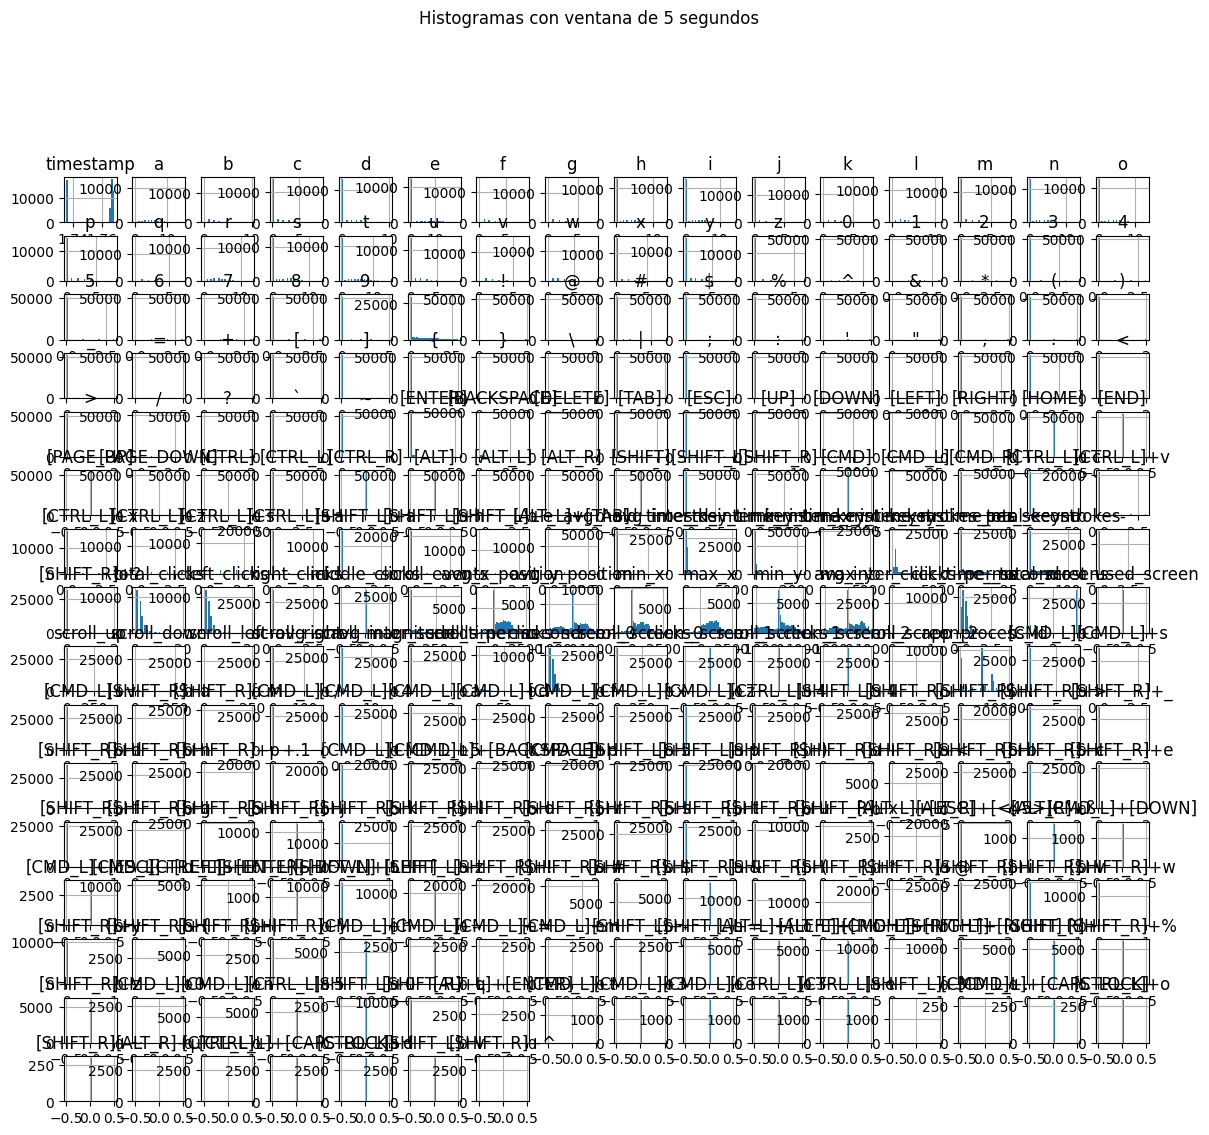

In [7]:

import matplotlib.pyplot as plt

num_cols_5 = df.select_dtypes(include='number').columns
df[num_cols_5].hist(bins=30, figsize=(14, 12))
plt.suptitle('Histogramas con ventana de 5 segundos', y=1.02)
# plt.tight_layout()
# plt.show()


In [16]:

# ==============================
# 1. Parámetros de agregación
# ==============================
base_window_sec   = 5
target_window_sec = 15

# cuántas ventanas originales se juntan en una ventana más grande
factor = target_window_sec // base_window_sec
print('factor de agregación:', factor)

# ==============================
# 2. Ordenar por tiempo
# ==============================
df = df.sort_values('timestamp').reset_index(drop=True)

# ==============================
# 3. Crear índice de grupo de ventana
# ==============================
# window_group indica a qué ventana agregada pertenece cada fila
# ventana 0: filas 0..factor-1
# ventana 1: filas factor..2*factor-1
df['window_group'] = df.index // factor

# ==============================
# 4. Cómo agregar cada columna
# ==============================
agg_dict = {
    # ---------- CONTEOS (se SUMAN) ----------
    # total de teclas presionadas en la ventana agregada
    'total_keystrokes': 'sum',
    # total de clics del mouse en la ventana agregada
    'total_clicks': 'sum',
    # total de clics izquierdos
    'left_clicks': 'sum',
    # total de clics derechos
    'right_clicks': 'sum',
    # total de clics con el botón del medio
    'middle_clicks': 'sum',
    # total de eventos de scroll
    'scroll_events': 'sum',
    # total de scroll hacia arriba / abajo / izquierda / derecha
    'scroll_up': 'sum',
    'scroll_down': 'sum',
    'scroll_left': 'sum',
    'scroll_right': 'sum',
    # suma de scrolls por segundo
    'scrolls_per_second': 'sum',

    # ---------- TIEMPOS Y PROMEDIOS (se promedian) ----------
    # tiempo promedio que se mantiene una tecla presionada (ms)
    'avg_hold_time_ms': 'mean',
    # tiempo promedio entre presionar una tecla y la siguiente (ms)
    'avg_inter_key_time_ms': 'mean',
    # promedio de la desviación estándar del tiempo entre teclas
    'std_inter_key_time_ms': 'mean',
    # menor tiempo entre teclas dentro de la ventana agregada
    'min_inter_key_time_ms': 'min',
    # mayor tiempo entre teclas dentro de la ventana agregada
    'max_inter_key_time_ms': 'max',
    # promedio de teclas por segundo en la ventana agregada
    'keystrokes_per_second': 'mean',
    # tiempo promedio entre clics sucesivos (ms)
    'avg_inter_click_time_ms': 'mean',
    # magnitud promedio del scroll
    'avg_scroll_magnitude': 'mean',
    # tiempo promedio entre eventos de scroll
    'avg_inter_scroll_time_ms': 'mean',
}

# ==============================
# 5. Agregar la etiqueta (active_application)
# ==============================
# dentro de cada ventana agregada, tomamos la aplicación más frecuente
agg_label = {
    'active_application': lambda x: x.value_counts().idxmax()
}

# ==============================
# 6. Aplicar groupby + agg
# ==============================
df_agg = (
    df.groupby('window_group')
      .agg({**agg_dict, **agg_label})
      .reset_index(drop=True)
)

print("Tamaño original:", df.shape)
print("Tamaño agregado:", df_agg.shape)

# ==============================
# 7. Preparar X, y para el modelo (opcional)
# ==============================
target_col  = 'active_application'
feature_cols = list(agg_dict.keys())

X = df_agg[feature_cols].copy()
y = df_agg[target_col].copy()
print("X, y:", X.shape, y.shape)


factor de agregación: 3
Tamaño original: (53498, 251)
Tamaño agregado: (17833, 21)
X, y: (17833, 20) (17833,)


# Paso 3: Filtrar Ventanas Activas

Se requiere filtrar ventans activas, almenos  considerar un minimo de intereciones en cada ventana

---



In [18]:
min_keystrokes  = 20
min_clicks      = 5
min_scroll      = 3

mask_activa = (
    (df_agg['total_keystrokes'] >= min_keystrokes) |
    (df_agg['total_clicks']      >= min_clicks)    |
    (df_agg['scroll_events']     >= min_scroll)
)

df_agg_active = df_agg[mask_activa].reset_index(drop=True)
print("Shape de DF con ventans de 15 segundos:", df_agg.shape, "shape de ventana activas de 15 segundos:", df_agg_active.shape)


Shape de DF con ventans de 15 segundos: (17833, 21) shape de ventana activas de 15 segundos: (16308, 21)


In [19]:
df_agg_active

,total_keystrokes,total_clicks,left_clicks,right_clicks,middle_clicks,scroll_events,scroll_up,scroll_down,scroll_left,scroll_right,...,avg_hold_time_ms,avg_inter_key_time_ms,std_inter_key_time_ms,min_inter_key_time_ms,max_inter_key_time_ms,keystrokes_per_second,avg_inter_click_time_ms,avg_scroll_magnitude,avg_inter_scroll_time_ms,active_application
0,124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,147.866667,172.800000,51.633333,80.7,371.6,8.266667,NaN,NaN,NaN,Slack
1,126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,141.566667,192.533333,64.600000,89.6,515.8,8.400000,NaN,NaN,NaN,Slack
2,115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,134.933333,230.500000,92.600000,93.4,543.4,7.666667,NaN,NaN,NaN,Slack
3,198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159.566667,218.333333,69.233333,100.8,508.3,13.200000,NaN,NaN,NaN,Slack
4,114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,144.333333,187.433333,81.366667,81.3,406.3,7.600000,NaN,NaN,NaN,Slack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16303,0,3.0,3.0,0.0,0.0,136.0,0.0,95.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.292792e+04,0.463333,388.626667,Google Chrome
16304,0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,3.663070e+06,0.000000,0.000000,Google Chrome
16305,0,4.0,4.0,0.0,0.0,159.0,85.0,35.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,3.946230e+03,1.093333,89488.073333,Firefox
16306,0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,3.854640e+03,0.000000,0.000000,Firefox


# PASO 4: Comportamiento de Aplicaciones: Slack vs. Google Chrome

Analizaremos los patrones de interacción para **Slack** y **Google Chrome** usando `df_agg_active`. Primero, mostraremos una fila de ejemplo para cada aplicación y luego visualizaremos la distribución de sus métricas clave con histogramas.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filtrar datos para Slack y Google Chrome
df_slack = df_agg_active[df_agg_active['active_application'] == 'Slack'].copy()
df_chrome = df_agg_active[df_agg_active['active_application'] == 'Google Chrome'].copy()

print("### Ejemplo de una fila para Slack:\n")
display(df_slack.sample(1, random_state=42))

print("\n### Ejemplo de una fila para Google Chrome:\n")
display(df_chrome.sample(1, random_state=42))

### Ejemplo de una fila para Slack:



,total_keystrokes,total_clicks,left_clicks,right_clicks,middle_clicks,scroll_events,scroll_up,scroll_down,scroll_left,scroll_right,...,avg_hold_time_ms,avg_inter_key_time_ms,std_inter_key_time_ms,min_inter_key_time_ms,max_inter_key_time_ms,keystrokes_per_second,avg_inter_click_time_ms,avg_scroll_magnitude,avg_inter_scroll_time_ms,active_application
2928,126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,154.033333,173.733333,67.2,64.3,460.2,8.4,NaN,NaN,NaN,Slack



### Ejemplo de una fila para Google Chrome:



,total_keystrokes,total_clicks,left_clicks,right_clicks,middle_clicks,scroll_events,scroll_up,scroll_down,scroll_left,scroll_right,...,avg_hold_time_ms,avg_inter_key_time_ms,std_inter_key_time_ms,min_inter_key_time_ms,max_inter_key_time_ms,keystrokes_per_second,avg_inter_click_time_ms,avg_scroll_magnitude,avg_inter_scroll_time_ms,active_application
2477,148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,145.733333,168.233333,61.1,82.4,428.7,9.866667,NaN,NaN,NaN,Google Chrome


# Paso 5: Histograma para Slack

Estos histogramas muestran la distribución de la actividad en Slack. Podemos observar el número total de pulsaciones de teclas, clics, eventos de scroll, y los tiempos promedio entre estas acciones.

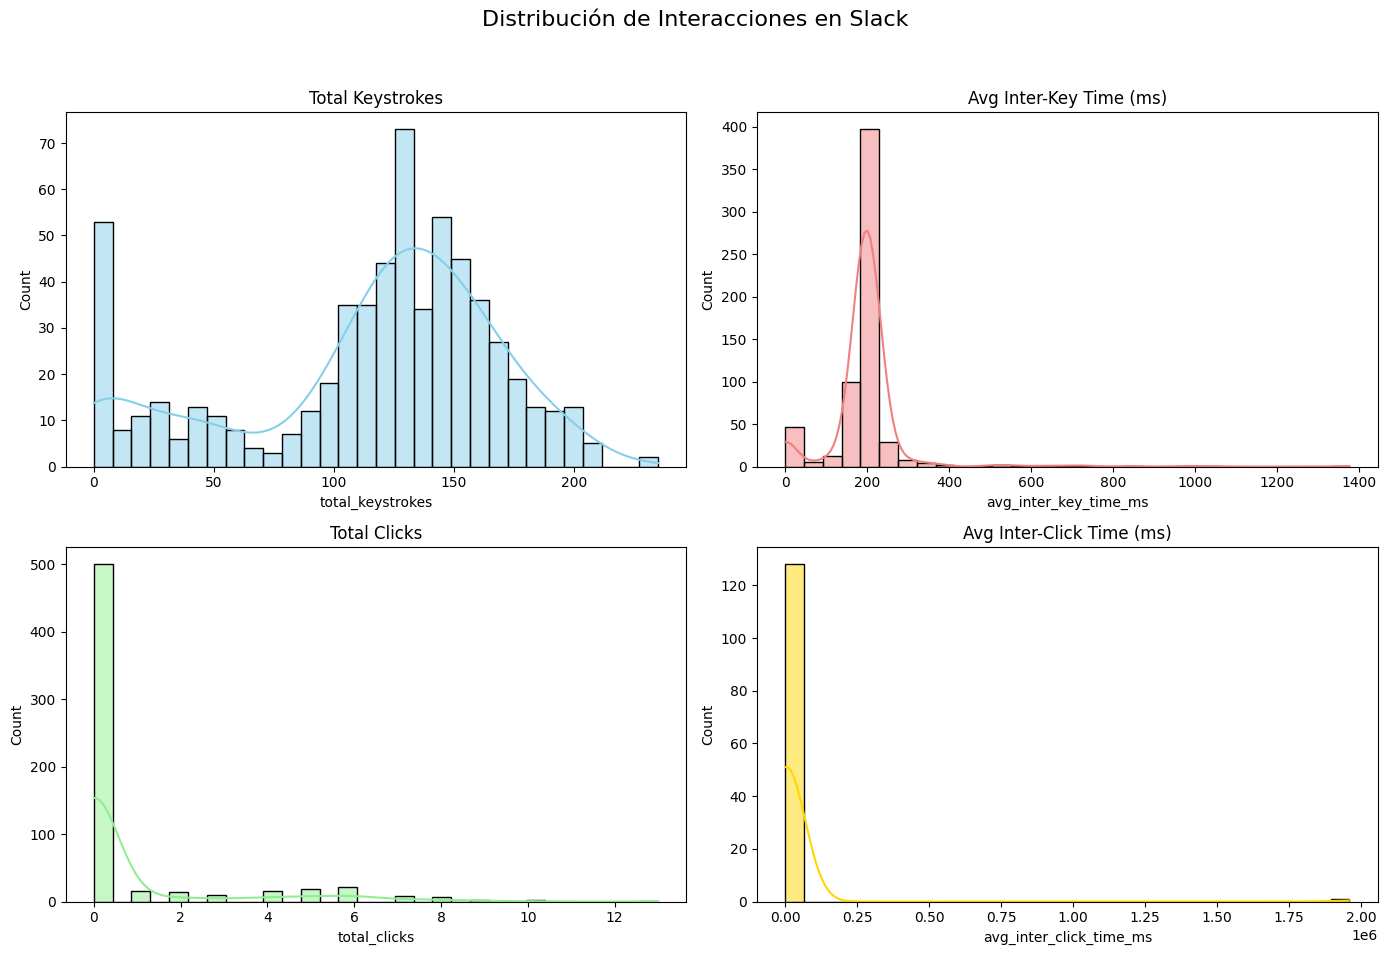

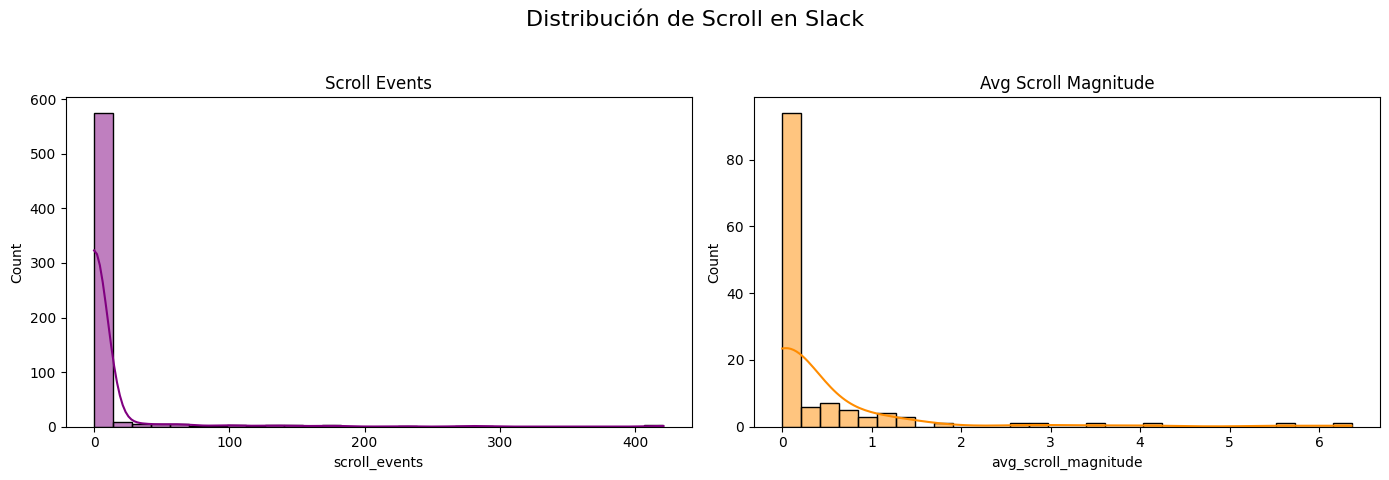

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Distribución de Interacciones en Slack', fontsize=16)

sns.histplot(df_slack['total_keystrokes'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Total Keystrokes')

sns.histplot(df_slack['avg_inter_key_time_ms'].dropna(), bins=30, kde=True, ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Avg Inter-Key Time (ms)')

sns.histplot(df_slack['total_clicks'], bins=30, kde=True, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Total Clicks')

sns.histplot(df_slack['avg_inter_click_time_ms'].dropna(), bins=30, kde=True, ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Avg Inter-Click Time (ms)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
fig.suptitle('Distribución de Scroll en Slack', fontsize=16)

sns.histplot(df_slack['scroll_events'], bins=30, kde=True, ax=axes[0], color='purple')
axes[0].set_title('Scroll Events')

sns.histplot(df_slack['avg_scroll_magnitude'].dropna(), bins=30, kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('Avg Scroll Magnitude')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Histograma para Google Chrome

Estos histogramas muestran la distribución de la actividad en Google Chrome. Podemos comparar estas distribuciones con las de Slack para identificar diferencias clave en el comportamiento del usuario.

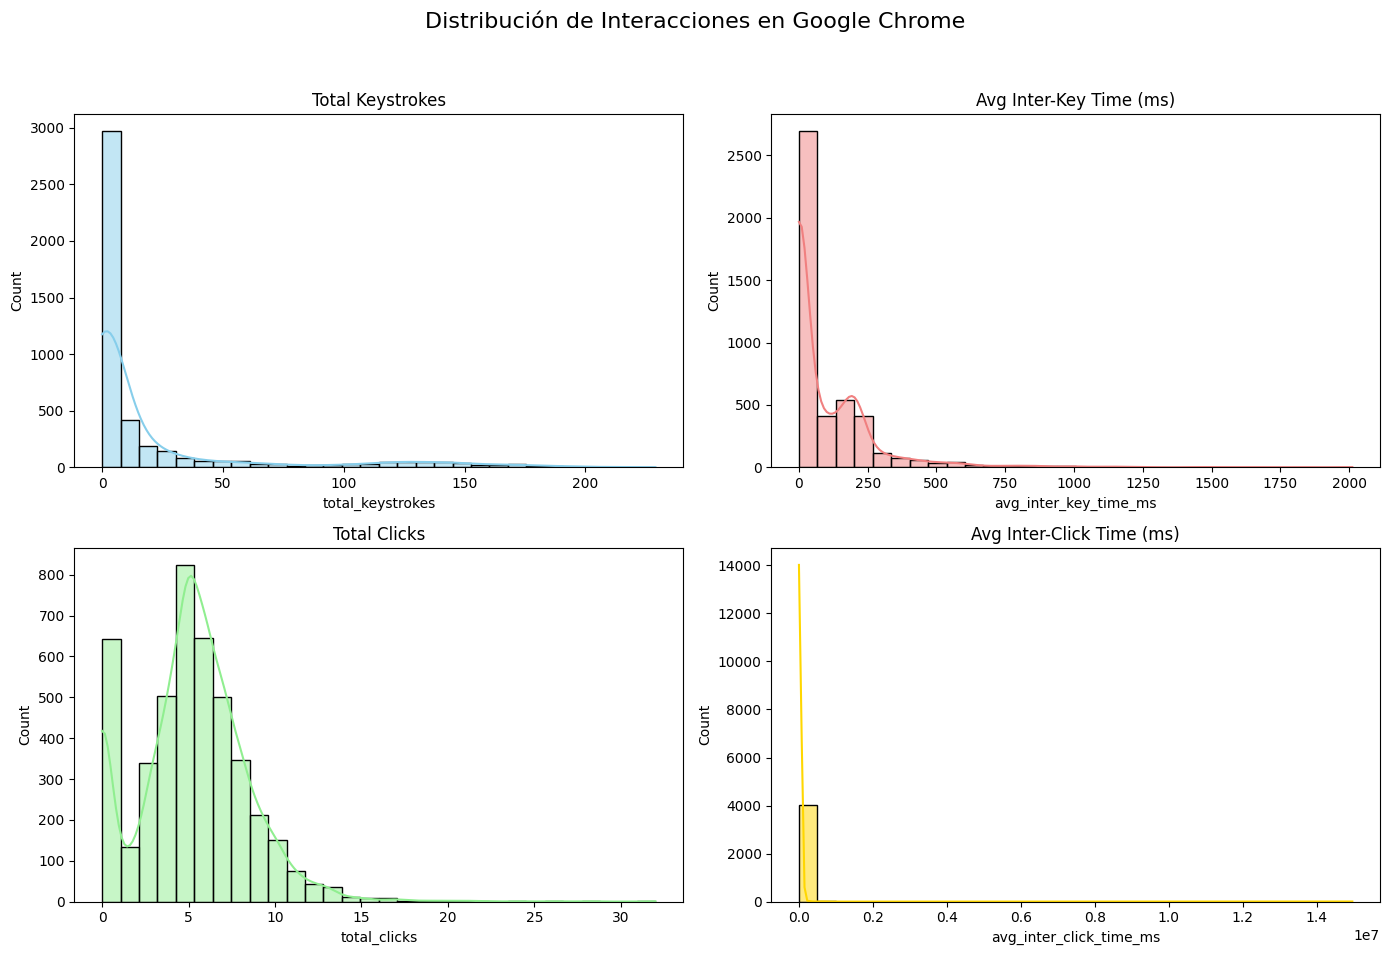

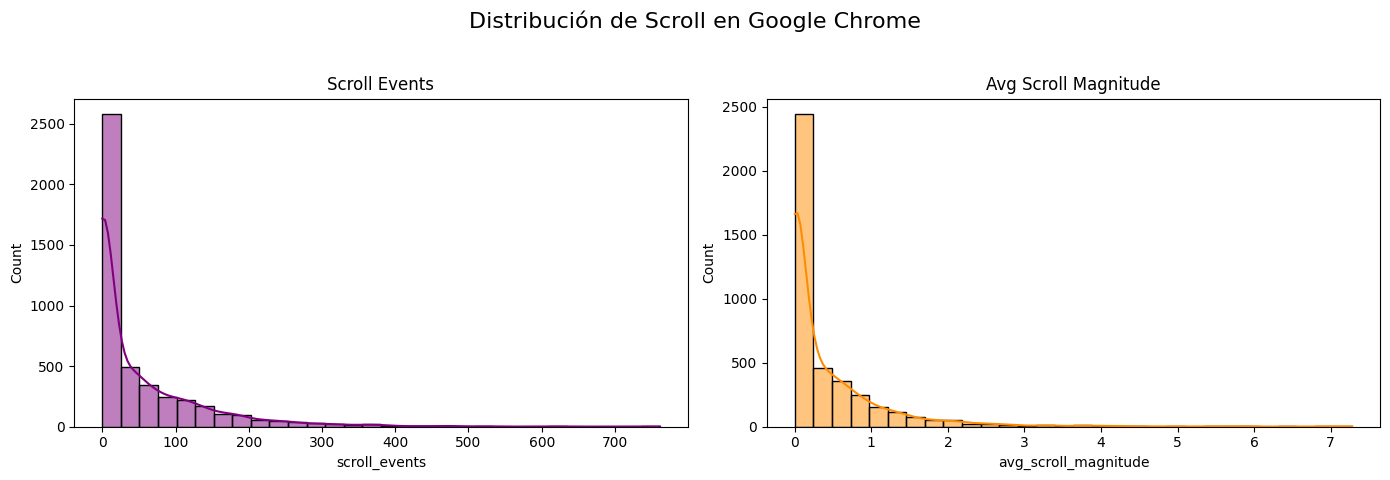

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Distribución de Interacciones en Google Chrome', fontsize=16)

sns.histplot(df_chrome['total_keystrokes'], bins=30, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Total Keystrokes')

sns.histplot(df_chrome['avg_inter_key_time_ms'].dropna(), bins=30, kde=True, ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Avg Inter-Key Time (ms)')

sns.histplot(df_chrome['total_clicks'], bins=30, kde=True, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Total Clicks')

sns.histplot(df_chrome['avg_inter_click_time_ms'].dropna(), bins=30, kde=True, ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Avg Inter-Click Time (ms)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
fig.suptitle('Distribución de Scroll en Google Chrome', fontsize=16)

sns.histplot(df_chrome['scroll_events'], bins=30, kde=True, ax=axes[0], color='purple')
axes[0].set_title('Scroll Events')

sns.histplot(df_chrome['avg_scroll_magnitude'].dropna(), bins=30, kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('Avg Scroll Magnitude')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Observaciones de los Comportamientos

#### Slack (aplicación de comunicación)

- **total_keystrokes:** Distribución concentrada en valores medios (aprox. 100–170 teclas por intervalo), con pocos casos muy bajos o muy altos, lo que indica sesiones de escritura relativamente constantes. [image:4]  
- **avg_inter_key_time_ms:** La mayoría de los valores se ubican en un rango estrecho alrededor de 150–250 ms, con una cola hacia tiempos más altos, reflejando un flujo de escritura continuo con pausas ocasionales. [image:4]  
- **total_clicks:** Predominan intervalos con 0–1 clic, y muy pocos superan los 5 clics, lo que sugiere que el ratón se usa de forma puntual (cambio de canal, abrir hilos) y que la interacción principal es por teclado. [image:4]  
- **avg_inter_click_time_ms:** Los tiempos entre clics suelen ser muy altos, con colas largas, coherentes con largos periodos de solo escritura o lectura entre clics esporádicos. [image:4]  

**En resumen para Slack:** El patrón dominante es de comunicación escrita sostenida, con mucha actividad de teclado y baja frecuencia de clics, típica de una herramienta de mensajería enfocada en el texto. [image:4]  

---

#### Google Chrome (navegador web)

- **total_keystrokes:** La mayoría de los intervalos tienen pocas teclas (cerca de 0–10), pero existe una cola que llega a valores altos, indicando que normalmente se navega o lee, con episodios puntuales de escritura intensa (formularios, comentarios, búsquedas). [image:3]  
- **avg_inter_key_time_ms:** Presenta mayor dispersión y sesgo a la derecha que Slack; coexisten tiempos cortos (cuando se escribe de forma continua) con tiempos muy largos, que representan pausas de lectura o navegación sin teclear. [image:3]  
- **total_clicks:** Distribución desplazada hacia valores más altos (picos alrededor de 4–7 clics por intervalo, llegando a 30+), reflejando un uso intensivo del ratón para abrir enlaces, cambiar pestañas y desplazarse por la interfaz. [image:3]  
- **avg_inter_click_time_ms:** Hay muchos intervalos con tiempos bajos entre clics (navegación rápida) y, al mismo tiempo, una cola extrema de tiempos muy altos, debida a periodos largos de lectura o pestañas inactivas entre clics. [image:3]  

**En resumen para Chrome:** El comportamiento es más heterogéneo, combinando lectura, navegación y momentos de escritura, con mucha más actividad de clics y distribuciones más amplias en todas las métricas respecto a Slack, lo que refleja la diversidad de tareas propias del navegador. [image:3]  


#  PASO 6: Filtrar Columnas Relevantes que usaremos


In [28]:
import pandas as pd

selected_columns = [
    'total_keystrokes',
    'avg_inter_key_time_ms',
    'total_clicks',
    'avg_inter_click_time_ms',
    'scroll_events',
    'avg_scroll_magnitude',
    'active_application'
]

df_filtered_features = df_agg_active[selected_columns].copy()

print("Shape del DataFrame filtrado:", df_filtered_features.shape)
print("\nPrimeras 5 filas del DataFrame filtrado:")
display(df_filtered_features.head())

Shape del DataFrame filtrado: (16308, 7)

Primeras 5 filas del DataFrame filtrado:


,total_keystrokes,avg_inter_key_time_ms,total_clicks,avg_inter_click_time_ms,scroll_events,avg_scroll_magnitude,active_application
0,124,172.800000,0.0,NaN,0.0,NaN,Slack
1,126,192.533333,0.0,NaN,0.0,NaN,Slack
2,115,230.500000,0.0,NaN,0.0,NaN,Slack
3,198,218.333333,0.0,NaN,0.0,NaN,Slack
4,114,187.433333,0.0,NaN,0.0,NaN,Slack


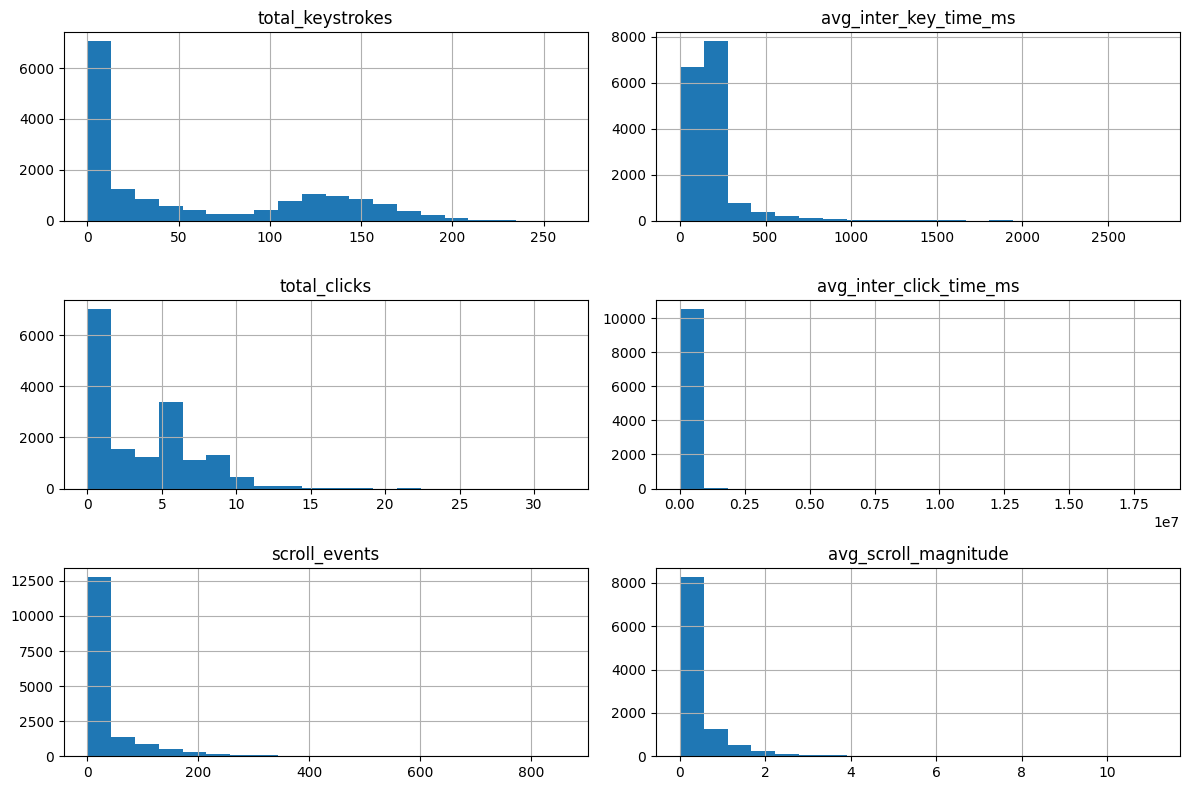

=== Media ===
total_keystrokes              58.035136
avg_inter_key_time_ms        170.654074
total_clicks                   3.363748
avg_inter_click_time_ms    14728.207960
scroll_events                 30.118408
avg_scroll_magnitude           0.352978
dtype: float64

=== Mediana ===
total_keystrokes             25.000000
avg_inter_key_time_ms       180.666667
total_clicks                  3.000000
avg_inter_click_time_ms    3468.458333
scroll_events                 0.000000
avg_scroll_magnitude          0.000000
dtype: float64

=== Moda ===
total_keystrokes           0.0
avg_inter_key_time_ms      0.0
total_clicks               0.0
avg_inter_click_time_ms    0.0
scroll_events              0.0
avg_scroll_magnitude       0.0
Name: 0, dtype: float64


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Si tu DataFrame no se llama df, cámbialo aquí
# df = ...

numeric_cols = [
    "total_keystrokes",
    "avg_inter_key_time_ms",
    "total_clicks",
    "avg_inter_click_time_ms",
    "scroll_events",
    "avg_scroll_magnitude",
]

# --------------------------
# 1) Histogramas generales
# --------------------------
df_filtered_features[numeric_cols].hist(
    bins=20,
    figsize=(12, 8),
    grid=True
)
plt.tight_layout()
plt.show()

# --------------------------
# 2) Medidas globales
# --------------------------
means = df_filtered_features[numeric_cols].mean(numeric_only=True)
medians = df_filtered_features[numeric_cols].median(numeric_only=True)
modes = df_filtered_features[numeric_cols].mode(numeric_only=True).iloc[0]  # primera fila de la moda

print("=== Media ===")
print(means)
print("\n=== Mediana ===")
print(medians)
print("\n=== Moda ===")
print(modes)

# # --------------------------
# # 3) Histogramas por aplicación activa (opcional)
# # --------------------------
# # Elige algunas apps que te interesen
# apps_interes = df["active_application"].value_counts().head(3).index

# for app in apps_interes:
#     subset = df[df["active_application"] == app]
#     if subset.empty:
#         continue
#     subset[numeric_cols].hist(
#         bins=20,
#         figsize=(12, 8),
#         grid=True
#     )
#     plt.suptitle(f"Distribución para active_application = {app}")
#     plt.tight_layout()
#     plt.show()


# Paso 7: Generar Distribucion de los datos,  Atravez de historgramas


# Generar Distribución de los datos a través de Histogramas

Vamos a crear histogramas para las columnas numéricas en `df_filtered_features` para entender mejor cómo se distribuyen los datos. Además, calcularemos la media, mediana y moda para cada una de estas columnas.

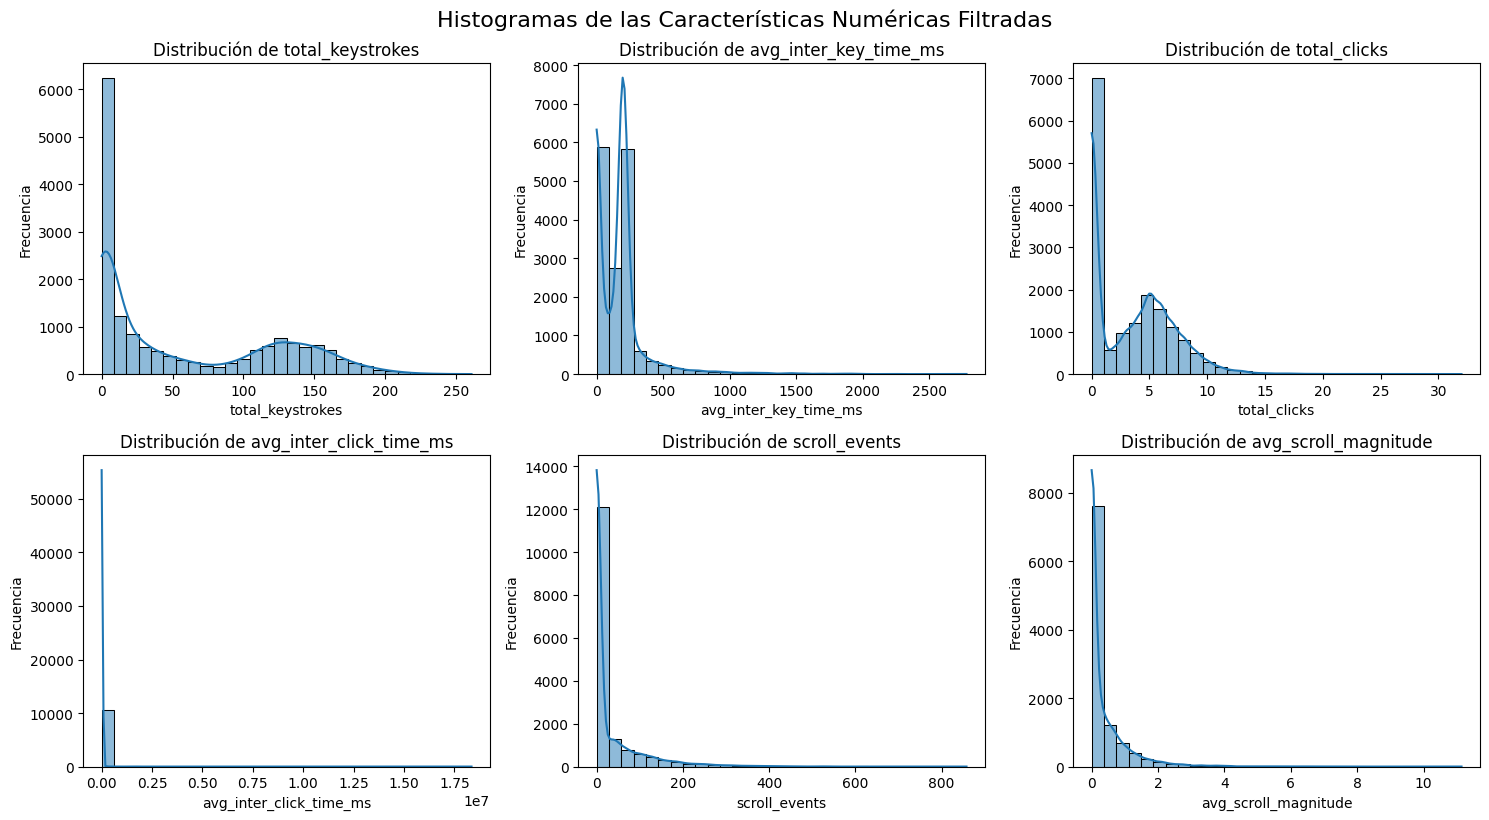


=== Media ===
total_keystrokes              58.035136
avg_inter_key_time_ms        170.654074
total_clicks                   3.363748
avg_inter_click_time_ms    14728.207960
scroll_events                 30.118408
avg_scroll_magnitude           0.352978
dtype: float64

=== Mediana ===
total_keystrokes             25.000000
avg_inter_key_time_ms       180.666667
total_clicks                  3.000000
avg_inter_click_time_ms    3468.458333
scroll_events                 0.000000
avg_scroll_magnitude          0.000000
dtype: float64

=== Moda ===
total_keystrokes           0.0
avg_inter_key_time_ms      0.0
total_clicks               0.0
avg_inter_click_time_ms    0.0
scroll_events              0.0
avg_scroll_magnitude       0.0
Name: 0, dtype: float64


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las columnas numéricas del DataFrame filtrado (excluyendo 'active_application')
numeric_cols_filtered = df_filtered_features.select_dtypes(include=np.number).columns.tolist()

# --------------------------
# 1) Histogramas generales
# --------------------------

# Determinar el número de filas y columnas para la subgráfica
num_features = len(numeric_cols_filtered)
num_cols_plot = 3 # Puedes ajustar este número
num_rows_plot = (num_features + num_cols_plot - 1) // num_cols_plot

fig, axes = plt.subplots(num_rows_plot, num_cols_plot, figsize=(5 * num_cols_plot, 4 * num_rows_plot))
axes = axes.flatten() # Aplanar para facilitar la iteración

for i, col in enumerate(numeric_cols_filtered):
    sns.histplot(df_filtered_features[col].dropna(), bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Histogramas de las Características Numéricas ', y=1.02, fontsize=16)
plt.show()

# --------------------------
# 2) Medidas globales
# --------------------------
means = df_filtered_features[numeric_cols_filtered].mean()
medians = df_filtered_features[numeric_cols_filtered].median()
modes = df_filtered_features[numeric_cols_filtered].mode().iloc[0] # Tomar la primera moda si hay varias

print("\n=== Media ===")
print(means)
print("\n=== Mediana ===")
print(medians)
print("\n=== Moda ===")
print(modes)


# Paso 8: Graficar los valores extremos (Outliers)

Los diagramas de caja (box plots) son una excelente herramienta para visualizar la distribución de los datos y, en particular, para identificar la presencia de valores atípicos o *outliers*.

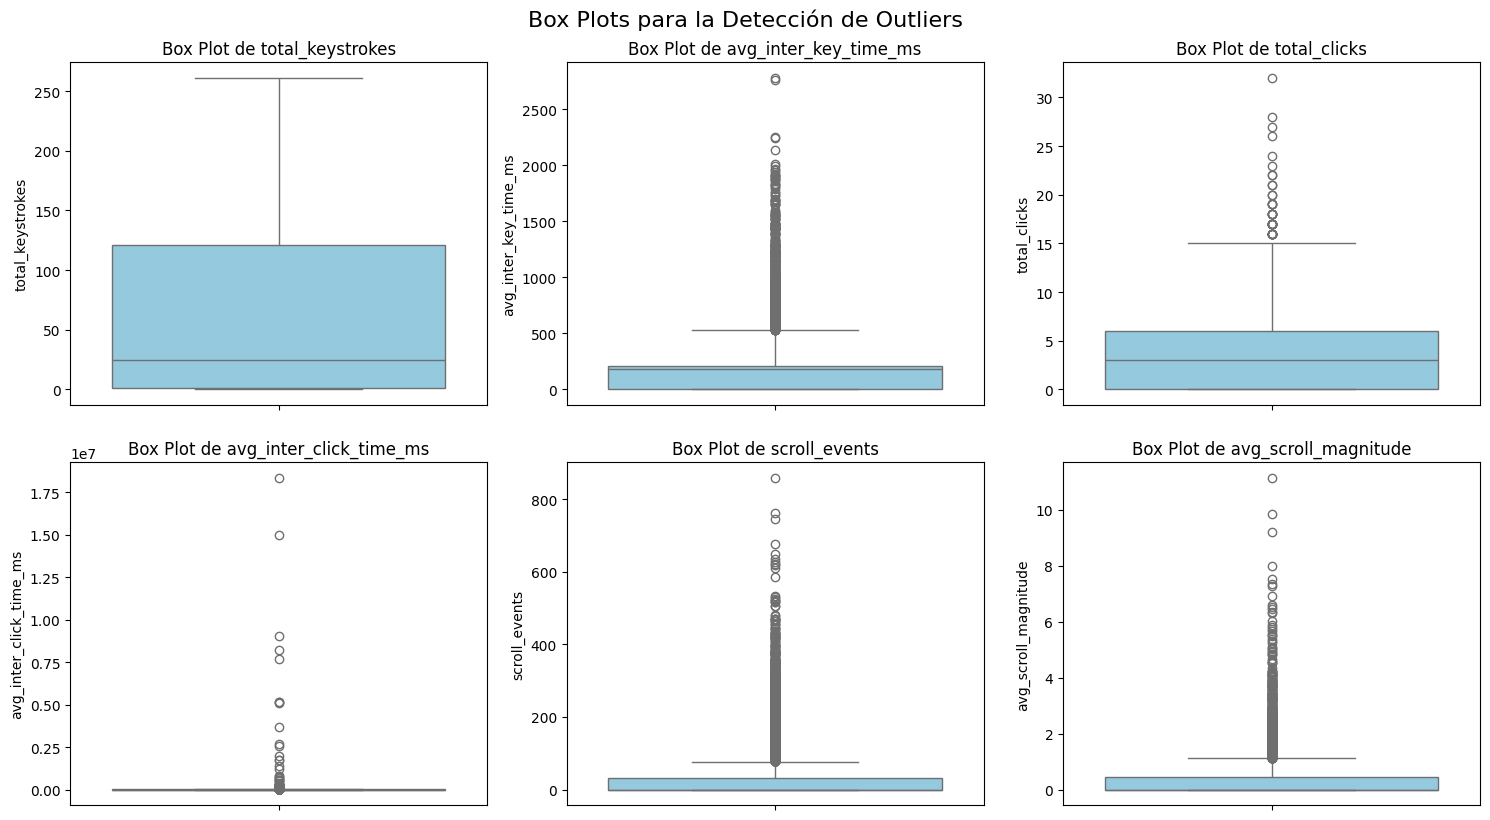

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Obtener las columnas numéricas del DataFrame filtrado (excluyendo 'active_application')
numeric_cols_filtered = df_filtered_features.select_dtypes(include=np.number).columns.tolist()

# Determinar el número de filas y columnas para la subgráfica
num_features = len(numeric_cols_filtered)
num_cols_plot = 3 # Puedes ajustar este número
num_rows_plot = (num_features + num_cols_plot - 1) // num_cols_plot

fig, axes = plt.subplots(num_rows_plot, num_cols_plot, figsize=(5 * num_cols_plot, 4 * num_rows_plot))
axes = axes.flatten() # Aplanar para facilitar la iteración

for i, col in enumerate(numeric_cols_filtered):
    sns.boxplot(y=df_filtered_features[col].dropna(), ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot de {col}')
    axes[i].set_ylabel(col)

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Box Plots para la Detección de Outliers', y=1.02, fontsize=16)
plt.show()

# Paso 9: CAP + LOG: Recortar Outliers Extremos y Comprimir Distribuciones

En este paso, aplicaremos dos técnicas para manejar los valores extremos (outliers) y normalizar las distribuciones de nuestras características numéricas:

1.  **Recorte (Clipping o Winsorización):** Limitaremos los valores de las características a un cierto percentil (por ejemplo, el 99%). Esto ayuda a reducir la influencia de los valores extremadamente altos sin eliminarlos por completo.
2.  **Transformación Logarítmica:** Aplicaremos una transformación logarítmica (usando `np.log1p` para manejar los ceros) a las características que presenten una distribución muy asimétrica a la derecha (skewed) o un rango muy amplio. Esto comprime la escala de los datos y los acerca a una distribución más normal.

In [33]:
import numpy as np
import pandas as pd

# Crear una copia del DataFrame para no modificar el original
df_processed = df_filtered_features.copy()

# Columnas numéricas a procesar (excluyendo la columna objetivo 'active_application')
numeric_cols_for_processing = df_processed.select_dtypes(include=np.number).columns.tolist()

print(f"Columnas numéricas a procesar: {numeric_cols_for_processing}")

# -----------------------------------------------------
# 1. Recorte (Clipping / Winsorización) de outliers
# -----------------------------------------------------
# Definimos un umbral superior (e.g., percentil 99) para el recorte.
# Para muchas de estas métricas, 0 es un valor significativo y no queremos recortar por debajo.

for col in numeric_cols_for_processing:
    upper_bound = df_processed[col].quantile(0.99) # Capping al 99 percentil
    df_processed[col] = np.clip(df_processed[col], a_min=None, a_max=upper_bound)
    print(f"Recorte aplicado a '{col}' (valores máximos limitados al {upper_bound:.2f})")

# -----------------------------------------------------
# 2. Transformación Logarítmica (log1p)
# -----------------------------------------------------
# Aplicamos log1p a las columnas que aún pueden tener distribuciones muy sesgadas.
# log1p = log(1+x) es útil porque maneja valores de 0 sin error y comprime la escala.

# Columnas para las que la transformación logarítmica es más beneficiosa
# Basado en la observación de los histogramas y box plots anteriores, estas suelen ser las más sesgadas.
log_transform_cols = [
    'total_keystrokes',
    'total_clicks',
    'scroll_events',
    'avg_inter_key_time_ms',
    'avg_inter_click_time_ms',
    'avg_scroll_magnitude'
]

for col in log_transform_cols:
    # Asegurarse de que la columna existe y es numérica
    if col in df_processed.columns and col in numeric_cols_for_processing:
        df_processed[col] = np.log1p(df_processed[col])
        print(f"Transformación logarítmica aplicada a '{col}'")

print("\nShape del DataFrame después del procesamiento:", df_processed.shape)
print("\nPrimeras 5 filas del DataFrame procesado:")
display(df_processed.head())

Columnas numéricas a procesar: ['total_keystrokes', 'avg_inter_key_time_ms', 'total_clicks', 'avg_inter_click_time_ms', 'scroll_events', 'avg_scroll_magnitude']
Recorte aplicado a 'total_keystrokes' (valores máximos limitados al 197.00)
Recorte aplicado a 'avg_inter_key_time_ms' (valores máximos limitados al 1113.25)
Recorte aplicado a 'total_clicks' (valores máximos limitados al 12.00)
Recorte aplicado a 'avg_inter_click_time_ms' (valores máximos limitados al 48324.67)
Recorte aplicado a 'scroll_events' (valores máximos limitados al 308.93)
Recorte aplicado a 'avg_scroll_magnitude' (valores máximos limitados al 3.27)
Transformación logarítmica aplicada a 'total_keystrokes'
Transformación logarítmica aplicada a 'total_clicks'
Transformación logarítmica aplicada a 'scroll_events'
Transformación logarítmica aplicada a 'avg_inter_key_time_ms'
Transformación logarítmica aplicada a 'avg_inter_click_time_ms'
Transformación logarítmica aplicada a 'avg_scroll_magnitude'

Shape del DataFrame de

,total_keystrokes,avg_inter_key_time_ms,total_clicks,avg_inter_click_time_ms,scroll_events,avg_scroll_magnitude,active_application
0,4.828314,5.157905,0.0,NaN,0.0,NaN,Slack
1,4.844187,5.265450,0.0,NaN,0.0,NaN,Slack
2,4.753590,5.444580,0.0,NaN,0.0,NaN,Slack
3,5.288267,5.390593,0.0,NaN,0.0,NaN,Slack
4,4.744932,5.238744,0.0,NaN,0.0,NaN,Slack


# Paso 10: Generar Distribución de los datos a través de Histogramas  con los datos procesado

Vamos a crear histogramas para las columnas numéricas en `df_processed` para entender mejor cómo se distribuyen los datos después del recorte de outliers y la transformación logarítmica. Además, calcularemos la media, mediana y moda para cada una de estas columnas procesadas.

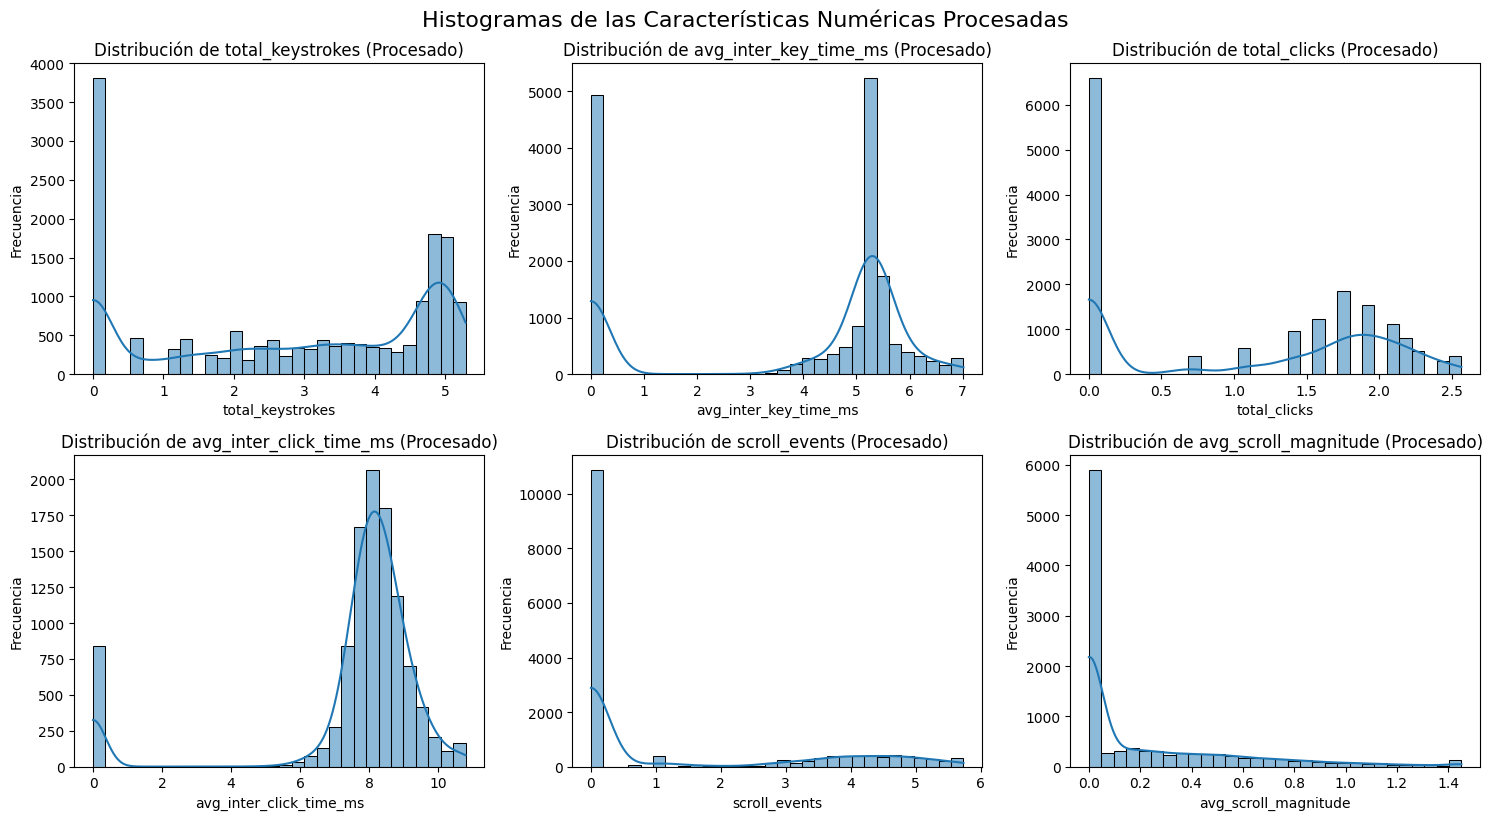


=== Media (Procesado) ===
total_keystrokes           2.838391
avg_inter_key_time_ms      3.704411
total_clicks               1.075787
avg_inter_click_time_ms    7.628548
scroll_events              1.325386
avg_scroll_magnitude       0.223430
dtype: float64

=== Mediana (Procesado) ===
total_keystrokes           3.258097
avg_inter_key_time_ms      5.202174
total_clicks               1.386294
avg_inter_click_time_ms    8.151754
scroll_events              0.000000
avg_scroll_magnitude       0.000000
dtype: float64

=== Moda (Procesado) ===
total_keystrokes           0.0
avg_inter_key_time_ms      0.0
total_clicks               0.0
avg_inter_click_time_ms    0.0
scroll_events              0.0
avg_scroll_magnitude       0.0
Name: 0, dtype: float64


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Obtener las columnas numéricas del DataFrame procesado
numeric_cols_processed = df_processed.select_dtypes(include=np.number).columns.tolist()

# --------------------------
# 1) Histogramas generales
# --------------------------

# Determinar el número de filas y columnas para la subgráfica
num_features = len(numeric_cols_processed)
num_cols_plot = 3 # Puedes ajustar este número
num_rows_plot = (num_features + num_cols_plot - 1) // num_cols_plot

fig, axes = plt.subplots(num_rows_plot, num_cols_plot, figsize=(5 * num_cols_plot, 4 * num_rows_plot))
axes = axes.flatten() # Aplanar para facilitar la iteración

for i, col in enumerate(numeric_cols_processed):
    sns.histplot(df_processed[col].dropna(), bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col} (Procesado)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Histogramas de las Características Numéricas Procesadas', y=1.02, fontsize=16)
plt.show()

# --------------------------
# 2) Medidas globales
# --------------------------
means_processed = df_processed[numeric_cols_processed].mean()
medians_processed = df_processed[numeric_cols_processed].median()
modes_processed = df_processed[numeric_cols_processed].mode().iloc[0] # Tomar la primera moda si hay varias

print("\n=== Media (Procesado) ===")
print(means_processed)
print("\n=== Mediana (Procesado) ===")
print(medians_processed)
print("\n=== Moda (Procesado) ===")
print(modes_processed)

# Paso 11: Matriz de Correlación

Después de procesar los datos, es crucial entender las relaciones entre las características. Una matriz de correlación nos mostrará cómo se relacionan linealmente cada par de variables numéricas en `df_processed`. Usaremos un mapa de calor (heatmap) para visualizar estas correlaciones de manera intuitiva.

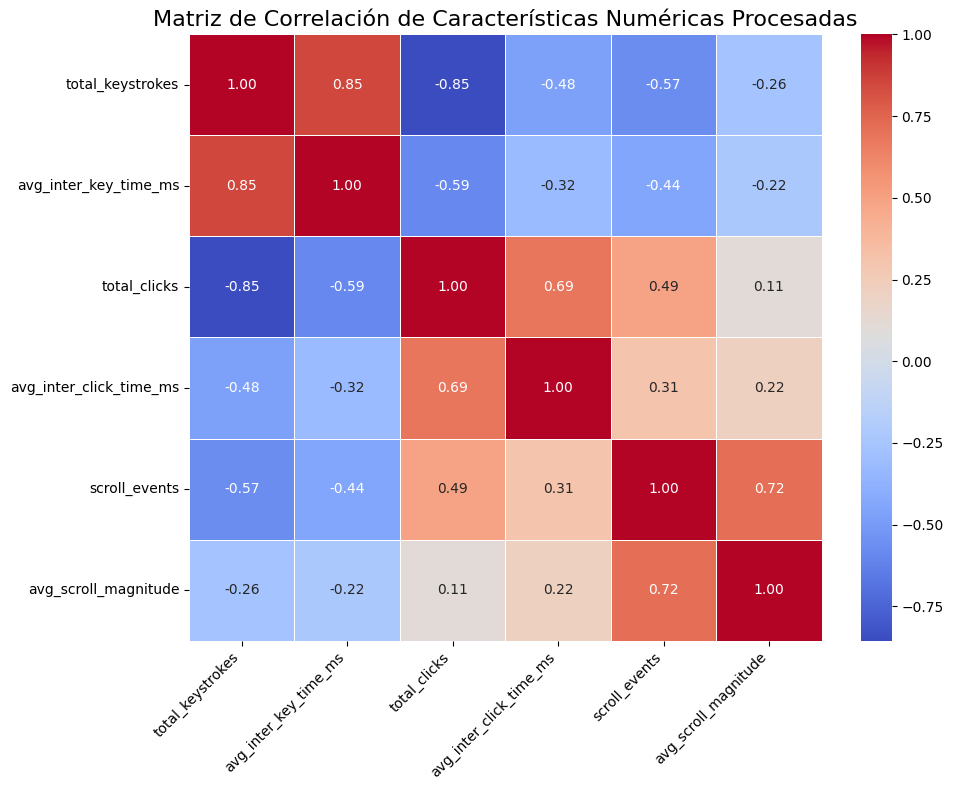


Matriz de Correlación (Valores Numéricos):



,total_keystrokes,avg_inter_key_time_ms,total_clicks,avg_inter_click_time_ms,scroll_events,avg_scroll_magnitude
total_keystrokes,1.000000,0.848255,-0.854572,-0.476921,-0.570549,-0.264446
avg_inter_key_time_ms,0.848255,1.000000,-0.591224,-0.323273,-0.443941,-0.224415
total_clicks,-0.854572,-0.591224,1.000000,0.688176,0.489619,0.107220
avg_inter_click_time_ms,-0.476921,-0.323273,0.688176,1.000000,0.307884,0.216639
scroll_events,-0.570549,-0.443941,0.489619,0.307884,1.000000,0.715817
avg_scroll_magnitude,-0.264446,-0.224415,0.107220,0.216639,0.715817,1.000000


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Obtener las columnas numéricas del DataFrame procesado
numeric_cols_processed = df_processed.select_dtypes(include=np.number).columns.tolist()

# Calcular la matriz de correlación
correlation_matrix = df_processed[numeric_cols_processed].corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear el mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Añadir título
plt.title('Matriz de Correlación de Características Numéricas Procesadas', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nMatriz de Correlación (Valores Numéricos):\n")
display(correlation_matrix)

# Paso 12: Guardar DataFrame Procesado en CSV

Guardaremos el `df_processed` en un archivo CSV en Google Drive para preservar los cambios realizados (recorte de outliers y transformación logarítmica). Esto permite que el DataFrame procesado sea reutilizado sin necesidad de repetir los pasos de preprocesamiento.

In [38]:
import pandas as pd

# Definir la ruta de salida para el DataFrame procesado
output_file_processed = 'drive/MyDrive/Machine_Learning_2025_2/trabajo_final/processed_keyboard_data.csv'

df_processed.to_csv(output_file_processed, index=False)



# Conteo de Filas por Aplicación Activa

Vamos a contar cuántas filas (o ventanas de tiempo procesadas) corresponden a cada aplicación activa en el DataFrame `df_processed`.

In [39]:
import pandas as pd

# Asegurarse de que df_processed está disponible (si no lo estuviera, cargarlo del CSV)
# if 'df_processed' not in locals():
#     output_file_processed = 'drive/MyDrive/Machine_Learning_2025_2/trabajo_final/processed_keyboard_data.csv'
#     df_processed = pd.read_csv(output_file_processed)

# Contar las ocurrencias de cada aplicación activa
app_counts = df_processed['active_application'].value_counts()

print("Conteo de filas por aplicación activa:\n")
display(app_counts)

Conteo de filas por aplicación activa:



,count
active_application,
Google Chrome,4490
Cursor,2450
‎WhatsApp,953
Firefox,632
iTerm2,626
Slack,615
Code,520
Copilot,490
Visual Studio Code,488


# Paso 13: Agrupar Aplicaciones por Categoría

Para simplificar el análisis y agrupar comportamientos similares, crearemos un diccionario de mapeo para categorizar las aplicaciones activas. Las aplicaciones que no entren en una categoría específica o que tengan una baja frecuencia se agruparán en 'Otros'.

In [43]:
import pandas as pd

# Definir el diccionario de mapeo de aplicaciones a categorías
app_category_map = {
    'Google Chrome': 'Navegadores',
    'Firefox': 'Navegadores',
    'Brave Browser': 'Navegadores',
    'Edge': 'Navegadores',
    'Safari': 'Navegadores',
    'Comet': 'Navegadores',
    '‎WhatsApp': 'Comunicación',
    'Slack': 'Comunicación',
    'Discord': 'Comunicación',
    'Microsoft Teams': 'Comunicación',
    'Zoom': 'Comunicación',

    'Code': 'IDE/Desarrollo',
    'Cursor': 'IDE/Desarrollo',
    'Copilot': 'IDE/Desarrollo',
    'Visual Studio Code': 'IDE/Desarrollo',
    'Antigravity': 'IDE/Desarrollo',

    'iTerm2': 'Desarrollo/Terminal',
    'Terminal': 'Desarrollo/Terminal',
    'WSL': 'Desarrollo/Terminal',

    'Excel': 'Otros',
    'Microsoft Word': 'Otros',

    'Youtube': 'Otros',
    'VLC': 'Otros',
    'QuickTime Player': 'Otros',
    'Photos': 'Otros',
    'Preview': 'Otros',
    'Finder': 'Otros',
    'Postico': 'Otros',
    'JOSM': 'Otros',
    'python': 'Otros',
    'loginwindow': 'Otros',
    'Docker Desktop': 'Otros'
}

# Crear la nueva columna 'application_category' en df_processed
# Usamos .get() con un valor por defecto 'Otros' para las aplicaciones no mapeadas
df_processed['application_category'] = df_processed['active_application'].apply(lambda x: app_category_map.get(x, 'Otros'))

print("Conteo de filas por nueva categoría de aplicación:\n")
display(df_processed['application_category'].value_counts())

Conteo de filas por nueva categoría de aplicación:



,count
application_category,
Navegadores,6446
IDE/Desarrollo,4141
Comunicación,2439
Otros,1855
Desarrollo/Terminal,1427


In [64]:
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt

# === 1. Partir SIEMPRE del df_processed original ===
df = df_processed.copy()

print("Conteos originales:")
print(df["application_category"].value_counts())
print()

# === 2. Definir clases minoritarias a duplicar ===
minor_classes = ["Comunicación", "Otros", "Desarrollo/Terminal"]

dfs = [df]  # empezamos con los datos originales

for cat in minor_classes:
    sub = df[df["application_category"] == cat]
    print(f"{cat} antes: {len(sub)}")
    sub_up = resample(
        sub,
        replace=True,
        n_samples=len(sub) * 1,   # exactamente el doble
        random_state=42,
    )
    print(f"{cat} agregado (nuevas filas): {len(sub_up)}")
    dfs.append(sub_up)

# === 3. Concatenar y ver nuevos conteos ===
df_balanced = pd.concat(dfs, ignore_index=True)

print("\nConteos después del oversampling:")
print(df_balanced["application_category"].value_counts())

# === 4. Gráfico antes / después con etiquetas


Conteos originales:
application_category
Navegadores            6446
IDE/Desarrollo         4141
Comunicación           2439
Otros                  1855
Desarrollo/Terminal    1427
Name: count, dtype: int64

Comunicación antes: 2439
Comunicación agregado (nuevas filas): 2439
Otros antes: 1855
Otros agregado (nuevas filas): 1855
Desarrollo/Terminal antes: 1427
Desarrollo/Terminal agregado (nuevas filas): 1427

Conteos después del oversampling:
application_category
Navegadores            6446
Comunicación           4878
IDE/Desarrollo         4141
Otros                  3710
Desarrollo/Terminal    2854
Name: count, dtype: int64


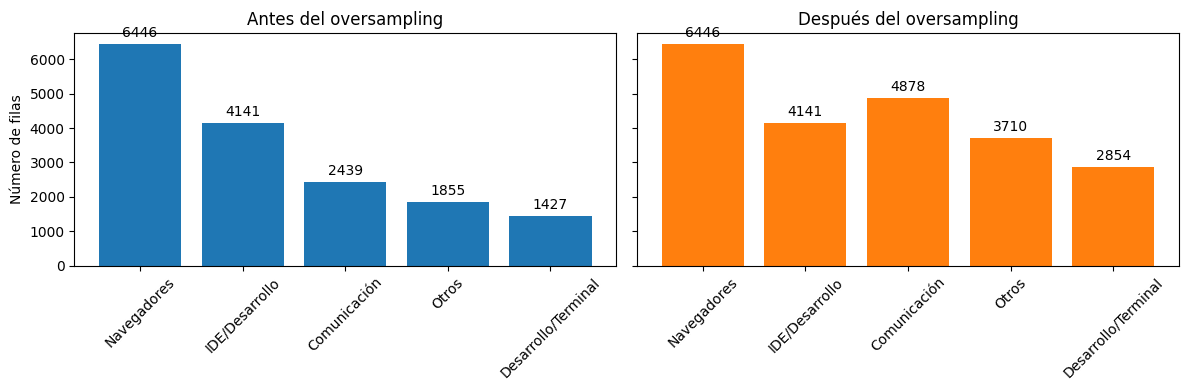

In [65]:
import matplotlib.pyplot as plt

# Orden fijo de categorías
cats = ["Navegadores", "IDE/Desarrollo", "Comunicación", "Otros", "Desarrollo/Terminal"]

# Conteos antes y después
before_counts = df_processed["application_category"].value_counts().reindex(cats)
after_counts  = df_balanced["application_category"].value_counts().reindex(cats)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- Antes del oversampling ---
bars_before = axes[0].bar(cats, before_counts.values, color="#1f77b4")
axes[0].set_title("Antes del oversampling")
axes[0].set_ylabel("Número de filas")
axes[0].tick_params(axis="x", rotation=45)
axes[0].bar_label(bars_before, labels=before_counts.values, padding=3)

# --- Después del oversampling ---
bars_after = axes[1].bar(cats, after_counts.values, color="#ff7f0e")
axes[1].set_title("Después del oversampling")
axes[1].tick_params(axis="x", rotation=45)
axes[1].bar_label(bars_after, labels=after_counts.values, padding=3)

plt.tight_layout()
plt.show()


# Task
Save the `df_balanced` DataFrame as a CSV file named "df_balanced_keyboard_data.csv" in the directory "drive/MyDrive/Machine_Learning_2025_2/trabajo_final/".

## Guardar DataFrame Balanceado en CSV

### Subtask:
Guardar el DataFrame `df_balanced` (el resultado del oversampling) en un archivo CSV en Google Drive, para que pueda ser utilizado en pasos posteriores o para su conservación.


# Task
Guardar el DataFrame `df_balanced` como un archivo CSV llamado "df_balanced_keyboard_data.csv" en la ruta "drive/MyDrive/Machine_Learning_2025_2/trabajo_final/".

## Guardar DataFrame Balanceado en CSV

### Subtask:
Guardar el DataFrame `df_balanced` (el resultado del oversampling) en un archivo CSV en Google Drive, para que pueda ser utilizado en pasos posteriores o para su conservación.


**Reasoning**:
I will save the `df_balanced` DataFrame to a CSV file in Google Drive using the specified path and ensuring `index=False`.



In [66]:
import pandas as pd

# 1. Definir la ruta de salida para el archivo CSV
output_file_balanced = 'drive/MyDrive/Machine_Learning_2025_2/trabajo_final/df_balanced_keyboard_data.csv'

# 2. Guardar el DataFrame df_balanced en la ruta especificada
df_balanced.to_csv(output_file_balanced, index=False)

print(f"DataFrame 'df_balanced' guardado exitosamente en: {output_file_balanced}")

DataFrame 'df_balanced' guardado exitosamente en: drive/MyDrive/Machine_Learning_2025_2/trabajo_final/df_balanced_keyboard_data.csv
